Exercise Sheet 7 **Radial basis function networks**

**7.1 Training Data**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist
import sys
from scipy.interpolate import griddata
from sklearn.cluster import KMeans

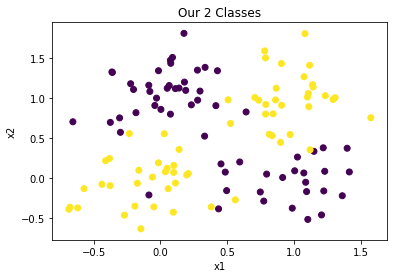

In [2]:
## Reminder: be careful of assigning two arrays to the same random sample 
# in the same line. 

#Our happy little mus
mu1 = np.array((0,1)).T
mu2 = np.array((1,0)).T
mu3 = np.array((0,0)).T
mu4 = np.array((1,1)).T

#creating our covariance matrix with variance .1
cov = np.eye(2)*.1

#Drawing multivariate normal distributions
mvd1 = np.random.multivariate_normal(mu1,cov,60)
mvd2 = np.random.multivariate_normal(mu2,cov,60)
mvd3 = np.random.multivariate_normal(mu3,cov,60)
mvd4 = np.random.multivariate_normal(mu4,cov,60)

# Choosing at random which distribution to draw from, then sampling
# from it

#Creating holder lists for our two mixture variables
holder1 = [mvd1, mvd2]
holder2 = [mvd3, mvd4]

#Preallocating empty array to hold samples
x0 = np.empty_like(mvd1)
x1 = np.empty_like(mvd1)

for i,x in enumerate(mvd1): 
    #Generating random probabilities
    prob1 = np.random.uniform(0,1)
    prob2 = np.random.uniform(0,1)
    
    #Choosing left or right summand at random, to be indexed as 0 or 1
    LorR1 = int(np.round(prob1))
    LorR2 = int(np.round(prob2))
    
    #Adding our sample from the multivariate normal distribution to the
    # array we created earlier
    x0[i] = holder1[LorR1][i]
    x1[i] = holder2[LorR2][i]


#Creating array of all our samples
x = np.concatenate([x0,x1])
    
#Creating our target values yt
yt0 = np.full(len(x0),0)
yt1 = np.full(len(x1),1)
yt = np.concatenate([yt0,yt1])

#Plotting those sweet, sweet data points
plt.scatter(x[:,0],x[:,1],c=yt)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Our 2 Classes')
plt.show()

**7.2 *k* nearest neighbors**

In [3]:
#Defining our kNN classfier

def kNN(newdata, k):
    ## Checking our inputs are valid
    
    # Reshaping new data/checking if one dimension contains
    # exactly 2 variables like our original data
    newdata = newdata.reshape(-1,2)
    
    #verifying one of the pre-decided k's is used
    possiblek = np.array((1,3,5))
    
    # if k matsches any value in our possiblek array,
    # continue
    if (k == possiblek).any() == False:
        sys.exit('Error: k not 1, 3, or 5')
    else: 
        ## The meat and potatoes (when in Deutschland...)

        #Insurance, in case we really mess up
        xc = newdata.copy()
        ytc = yt.copy()
        
        #Creating array just for new data points' ground truths
        ytnew = np.empty_like(ytc)

        #Calculate euclidean distance between all points
        metric = 'euclidean'
        dist = cdist(xc,newdata,metric)

        for i in range(len(newdata)):

            # Sorting, generating array with with the k smallest
            # distances in the first k elements
            idxs = np.argpartition(dist[:,i], k)

            #calling k closest neighbors' ground truths 
            kclosest = ytc[idxs[:k]]

            #finding whether more of k neihgbors are 0 or 1
            newlabel = round(np.sum(kclosest)/k)

            #Adding label to ground truth array
            ytnew[i] = newlabel  

        return ytnew

In [4]:
#defining plotting function, for both scatter and contour
def grid(X,Y,Z):
    xi = np.linspace(np.min(X)-.1, np.max(X)+.1, 100)
    yi = np.linspace(np.min(Y)-.1, np.max(Y)+.1, 100)
    zi = griddata((X,Y), Z, (xi[None,:], yi[:,None]), method='nearest')
    plt.contour(xi, yi, zi)
    plt.scatter(X,Y,c=Z)
    plt.xlabel('x1')
    plt.ylabel('x2')

From the plot, we can see that smaller values of k overfit the data, while larger values make the classifiers prediction more generalizable.

**7.3 Parzen Window Classifier**

In [5]:
## 7.3a

#Defining our kNN classfier

def kNNparzen(newdata, yt, k, variance):
    ## Checking our inputs are valid
    
    # Reshaping new data/checking if one dimension contains
    # exactly 2 variables like our original data
    newdata = newdata.reshape(-1,2)
    
    #verifying one of the pre-decided k's is used
    possiblek = np.array((1,3,5))
    
    # if k matsches any value in our possiblek array,
    # continue
    if (k == possiblek).any() == False:
        sys.exit('Error: k not 1, 3, or 5')
    else: 

        #Insurance copies of our training data
        xc = newdata.copy()
        ytc = yt.copy()
        
        #Creating array just for new data points' ground truths
        ytnew = np.empty_like(ytc)

        #Calculate euclidean distance between all points
        metric = 'euclidean'
        dist = cdist(xc,newdata,metric)
        
        #And calculate distance with parzen windown
        parzendist = np.e**((-1/(2*variance))*dist**2)

        for i in range(len(newdata)):

            #creating scoreboard for each class
            c1 = 0
            c2 = 0
            c3 = 0
    
            for j in range(len(newdata)):
                if ytc[j] == 0:
                    c1 += parzendist[j,i]
                elif ytc[j] == 1:
                    c2 += parzendist[j,i]
                else:
                    c3 += parzendist[j,i]
            
            scores = [c1,c2,c3]

            #Adding label to ground truth array
            ytnew[i] = np.argmax(scores)
            
        return ytnew

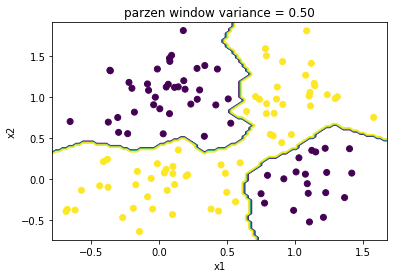

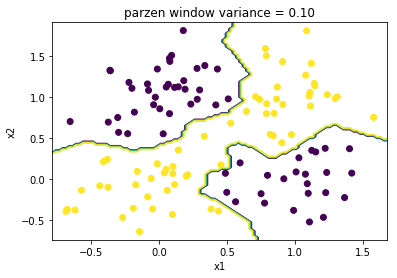

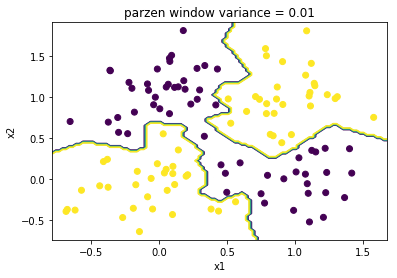

In [6]:
#defining our variances
sig = np.array([.5,.1,.01])

for i,s in enumerate(sig):
    z = kNNparzen(x,yt,5,s)
    grid(x[:,0],x[:,1],z)
    plt.title('parzen window variance = {:.2f}'.format(s))
    plt.show()

In [7]:
## 7.3b

#Creating 60 data points of new class
cov = np.eye(2)*.05
class3mu = np.array([.5,.5]).T
mvdclass3 = np.random.multivariate_normal(class3mu,cov,60)

#creating array to hold all 180 samples
x180 = np.concatenate([x,mvdclass3])

#updateing labels
class3yt = np.ones((60))*3
yt180 = np.concatenate([yt,class3yt])

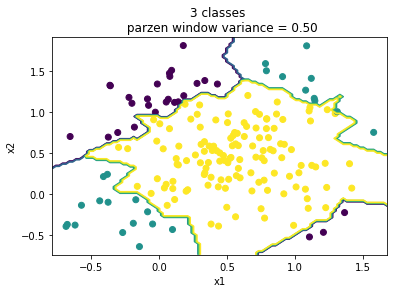

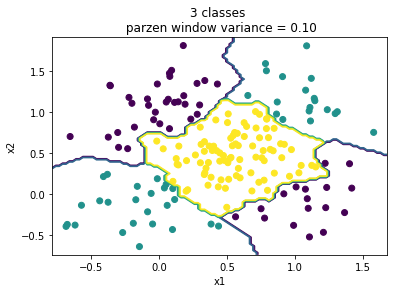

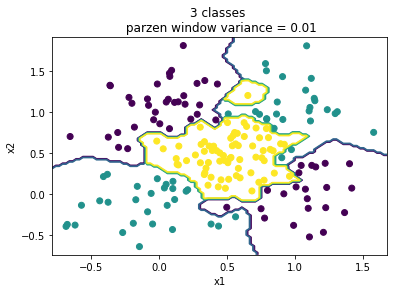

In [8]:
#setting our k neighbors to 5
for i,s in enumerate(sig):
    z = kNNparzen(x180,yt180,5,s)
    grid(x180[:,0],x180[:,1],z)
    plt.title('3 classes \n parzen window variance = {:.2f}'.format(s))
    plt.show()

Compared to the previous result, we have a new class that's smack dab in the middle of our original 2 classes. At k=5, we see the classifier becomes more conservative with the points it assigns to class 3 as the parzen window variance decreases. With a very high variance, it seems the classifier's electoral committee is giving a lot of voting weight to most centrally located class. 

**7.4 RBF Networks**

In [9]:
# 7.4a
#defining the step function
def step(h):
    steph = np.empty_like(h)
    for i,x in enumerate(h):
        if x >= .5:
            steph[i] = 1
        else:
            steph[i] = 0
    return steph


#defining our omega(x)
def kappa(newdata,X,var):
    #Calculate euclidean distance between all points
    metric = 'euclidean'
    dist = cdist(X,newdata,metric)

    #And calculate distance with parzen windown
    parzendist = np.e**((-1/(2*var))*dist**2)
    return parzendist

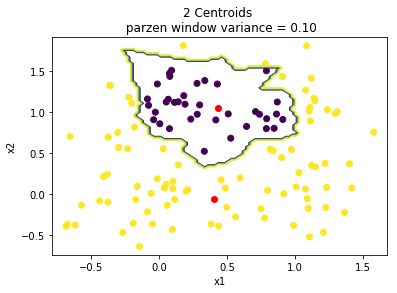

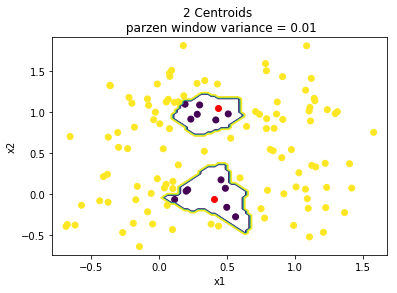

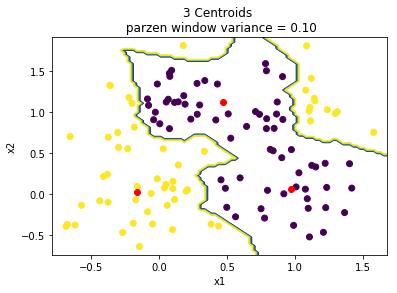

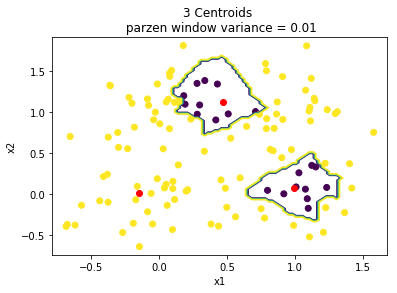

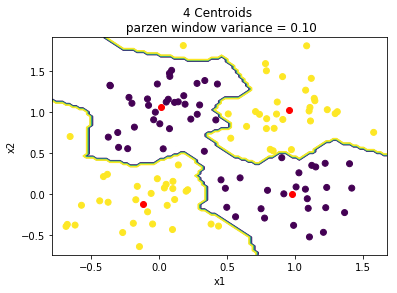

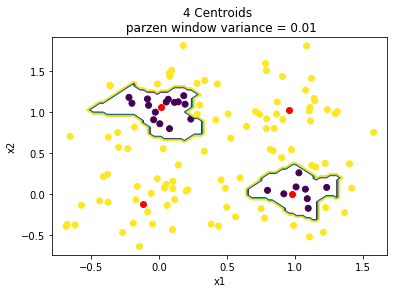

In [10]:
#Choosing our two reasonable kernel widths and our number of centroids
variance = [.1, .01]
num_reps = [2, 3, 4]

for i,K in enumerate(num_reps):
    for j,s in enumerate(variance):
    
        #Choosing K centroids, specifically 8
        t = KMeans(K,'k-means++') .fit(x)
        centroids = t.cluster_centers_

        # (k + 1)-dimensional vector containing the bias and our kappa basis 
        # function values
        omegax = kappa(centroids,x,s).T

        #creating bias vector
        bias = np.ones(omegax.shape[1])[:,np.newaxis].T

        #finishing our definition of omega(x)
        omegax = np.concatenate([bias,omegax])
        assert(omegax.shape == (K+1,120))

        #determining weight vector
        w = np.dot(np.dot(np.linalg.inv(np.dot(omegax,omegax.T)),omegax),yt)
        assert(w.shape == (K+1,))

        #solving for our predicted classification for query point x
        y = step(np.dot(w.T,omegax))
        
        #Plotting it all
        grid(x[:,0],x[:,1],y)
        plt.scatter(centroids[:,0],centroids[:,1],c='r')
        plt.title('{:d} Centroids \n parzen window variance = {:.2f}'.format(K,s))
        plt.show()

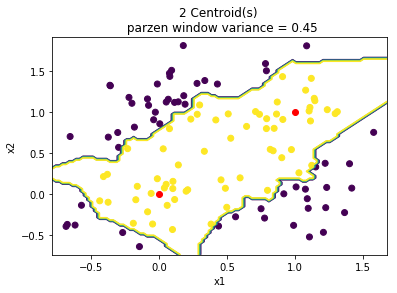

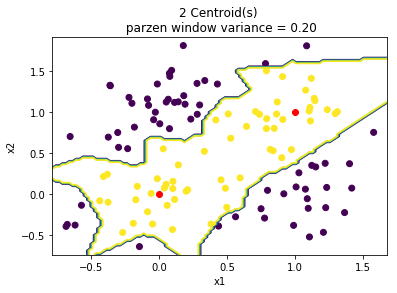

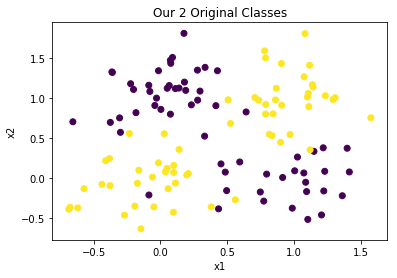

In [11]:
## 7.4b

#Choosing our two reasonable kernel widths and our number of centroids
variance = [.45,.2]
num_reps = [2]

for i,K in enumerate(num_reps):
    for j,s in enumerate(variance):
    
        #Choosing 2 centroids: t1, t2
        cent = np.array(([0,0],[1,1]))

        # (k + 1)-dimensional vector containing the bias and our kappa basis 
        # function values
        
        ## Must cdist take the argument of a two-dimensional array??
        omegax = kappa(cent,x,s).T

        #creating bias vector
        bias = np.ones(omegax.shape[1])[:,np.newaxis].T

        #finishing our definition of omega(x)
        omegax = np.concatenate([bias,omegax])
        assert(omegax.shape == (K+1,120))

        #determining weight vector
        w = np.dot(np.dot(np.linalg.inv(np.dot(omegax,omegax.T)),omegax),yt)
        assert(w.shape == (K+1,))

        #solving for our predicted classification for query point x
        y = step(np.dot(w.T,omegax))
        
        #Plotting φ1(x(α)) vs. φ2(x(α))
        grid(x[:,0],x[:,1],y)
        plt.scatter(cent[:,0],cent[:,1],c='r')
        plt.title('{:d} Centroid(s) \n parzen window variance = {:.2f}'.format(K,s))
        plt.show()
        

#Plotting those sweet, sweet original data points
yt = np.concatenate([yt0,yt1])
plt.scatter(x[:,0],x[:,1],c=yt)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Our 2 Original Classes')
plt.show()

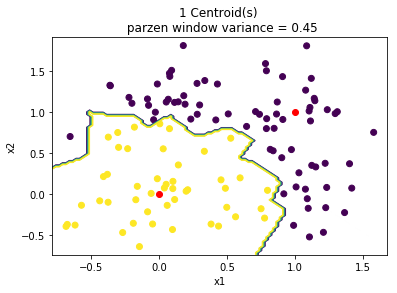

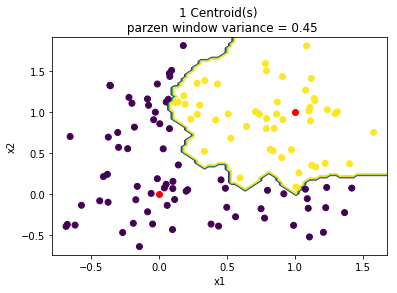

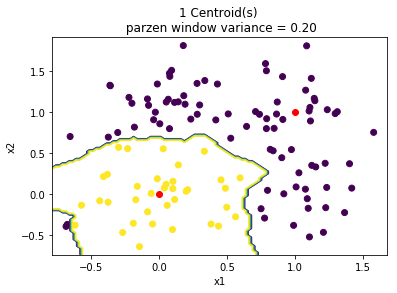

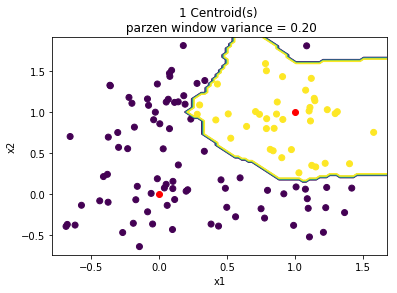

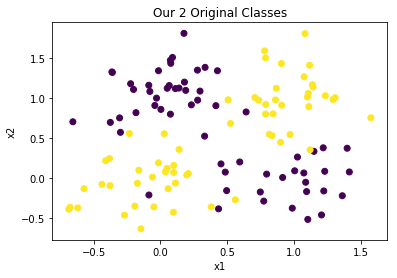

In [12]:
## 7.4b, intepreting intructions to plot φ1(x(α)) vs. φ2(x(α)) a bit differently...

#Choosing our two reasonable kernel widths and our number of centroids
variance = [.45,.2]
num_reps = [1,1]

for j,s in enumerate(variance):
    for i,K in enumerate(num_reps):
    
        #Choosing 2 centroids: t1, t2
        cent = np.array(([0,0],[1,1]))

        # (k + 1)-dimensional vector containing the bias and our kappa basis 
        # function values
        
        ## Must cdist take the argument of a two-dimensional array??
        omegax = kappa(cent[i].reshape(1,2),x,s).T

        #creating bias vector
        bias = np.ones(omegax.shape[1])[:,np.newaxis].T

        #finishing our definition of omega(x)
        omegax = np.concatenate([bias,omegax])
        assert(omegax.shape == (K+1,120))

        #determining weight vector
        w = np.dot(np.dot(np.linalg.inv(np.dot(omegax,omegax.T)),omegax),yt)
        assert(w.shape == (K+1,))

        #solving for our predicted classification for query point x
        y = step(np.dot(w.T,omegax))
        
        #Plotting φ1(x(α)) vs. φ2(x(α))
        grid(x[:,0],x[:,1],y)
        plt.scatter(cent[:,0],cent[:,1],c='r')
        plt.title('{:d} Centroid(s) \n parzen window variance = {:.2f}'.format(K,s))
        plt.show()
        
#Plotting those sweet, sweet original data points
yt = np.concatenate([yt0,yt1])
plt.scatter(x[:,0],x[:,1],c=yt)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Our 2 Original Classes')
plt.show()
